## Bayesian convolutional neural network

A Bayesian convolutional neural network to classify the famous MNIST handwritten digits.A probabilistic model, designed to capture both aleatoric and epistemic uncertainty. 

In [2]:
# Heavily based on https://www.coursera.org/learn/probabilistic-deep-learning-with-tensorflow2/programming/QPF47/bayesian-convolutional-neural-network

#### PACKAGE IMPORTS ####

import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

tfd = tfp.distributions
tfpl = tfp.layers

#limit the training size to check code
train_size = 60000

In [3]:
# Function to load training and testing data, with labels in integer and one-hot form

def load_data(name):
    data_dir = os.path.join('data', name)
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [4]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

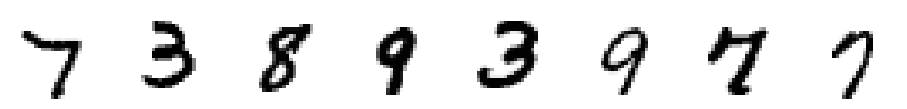

In [5]:
# Load and inspect the MNIST dataset
(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh) = load_data('MNIST')
inspect_images(data=x_train, num_images=8)

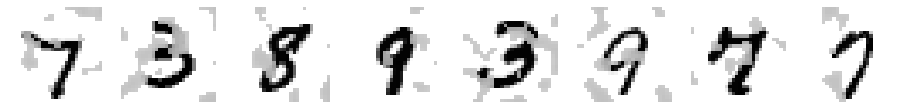

In [6]:
# Load and inspect the MNIST-C dataset
(x_c_train, y_c_train, y_c_train_oh), (x_c_test, y_c_test, y_c_test_oh) = load_data('MNIST_corrupted')
inspect_images(data=x_c_train, num_images=8)

In [7]:
# benchmark using a deterministic model
def get_deterministic_model(input_shape, loss, optimizer, metrics):

    model = Sequential([
        Conv2D(filters=8,kernel_size=(5,5),activation='relu',padding="VALID",input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=10,activation="softmax")
        
    ])
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    return model

tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy'])

In [8]:
# Train the model

deterministic_model.fit(x_train[:train_size], y_train[:train_size], epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4865 - accuracy: 0.8700
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1489 - accuracy: 0.9557
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1181 - accuracy: 0.9641
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1033 - accuracy: 0.9683
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0943 - accuracy: 0.9716


In [9]:
# Evaluate the model trained on the uncorrupted data on both datasets

print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test[:train_size], y_test[:train_size], verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test[:train_size], y_c_test[:train_size], verbose=False)[1]))

Accuracy on MNIST test set:  0.9735000133514404
Accuracy on corrupted MNIST test set:  0.941100001335144


In [10]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

def get_probabilistic_model(input_shape, loss, optimizer, metrics):
  
    divergence_fn = lambda q,p,_ : tfd.kl_divergence(q,p)/x_train.shape[0]
    
    model = Sequential([
        Conv2D(filters=8,kernel_size=(5,5),activation='relu',padding="VALID",input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=tfpl.OneHotCategorical.params_size(10),activation=None),
        tfpl.OneHotCategorical(10,convert_to_tensor_fn=tfd.Distribution.mode)
    ])
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    return model
    
tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy']
    )

In [11]:
# Train the model
probabilistic_model.fit(x_train[:train_size], y_train_oh[:train_size], epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4865 - accuracy: 0.8700
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1489 - accuracy: 0.9557
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1181 - accuracy: 0.9641
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1033 - accuracy: 0.9683
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0943 - accuracy: 0.9716


In [12]:
# Evaluate the model which now has a probabalistic element to the output. 
# Get the same results with the same seed on the mean of the distribution.

print('Accuracy on MNIST test set: ',
      str(probabilistic_model.evaluate(x_test[:train_size], y_test_oh[:train_size], verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(probabilistic_model.evaluate(x_c_test[:train_size], y_c_test_oh[:train_size], verbose=False)[1]))

Accuracy on MNIST test set:  0.9735000133514404
Accuracy on corrupted MNIST test set:  0.941100001335144


In [13]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=True):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    #print(predicted_probabilities.shape)
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    #print('difference between 2.5 & 97.5 percentile :',pct_97p5-pct_2p5)
    plt.show()

In [15]:
# The probabilistic model above considers only aleatoric uncertainty, assigning probabilities to each image instead 
# of deterministic labels. The model still had deterministic weights.
# there is also 'epistemic' uncertainty over the weights, due to uncertainty about the parameters that
# explain the training data. We will deal with this using a reparameterisation layer
# https://en.wikipedia.org/wiki/Variational_Bayesian_methods

def get_convolutional_reparameterization_layer(input_shape, divergence_fn):

    layer = tfpl.Convolution2DReparameterization(input_shape=input_shape, 
                    filters=8, 
                    kernel_size=(5,5), 
                    activation='relu',
                    padding ='VALID',
                    kernel_prior_fn =tfpl.default_multivariate_normal_fn, 
                    kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                    kernel_divergence_fn =divergence_fn,
                    bias_prior_fn =tfpl.default_multivariate_normal_fn, 
                    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                    bias_divergence_fn =divergence_fn,
        )
    return layer 

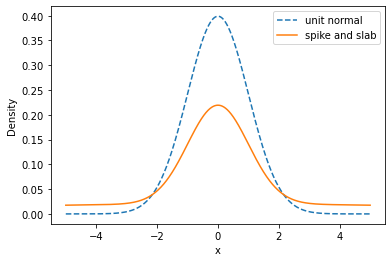

In [16]:
# Function to define the spike and slab distribution to use as the prior distribution

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

# Plot the spike and slab distribution pdf

x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

def get_prior(kernel_size, bias_size, dtype=None):
    event_shape = kernel_size + bias_size
    model = Sequential([
        tfpl.DistributionLambda(make_distribution_fn=lambda t: spike_and_slab(event_shape, dtype))
        
    ])
    return model

In [17]:
def get_posterior(kernel_size, bias_size, dtype=None):

    n = (kernel_size + bias_size) 
    model = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),dtype=dtype),
        tfpl.IndependentNormal(n)
        
    ])
    return model

def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):

    layer =   tfpl.DenseVariational(
                         units=10,
                         make_prior_fn=prior_fn,
                         make_posterior_fn=posterior_fn,
                         kl_weight = kl_weight,
                         kl_use_exact = False)
    return layer

tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train[:train_size].shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/x_train[:train_size].shape[0]
)


In [23]:
# Build and compile the Bayesian CNN model

bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
    ])


bayesian_model.compile(loss=nll,
             optimizer=RMSprop(),
             metrics=['accuracy'],
             experimental_run_tf_function=False)
    

In [19]:
# Train the model

bayesian_model.fit(x=x_train[:train_size], y=y_train_oh[:train_size], epochs=10, verbose=True)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9962 - accuracy: 0.3148
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7290 - accuracy: 0.7663
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4014 - accuracy: 0.8794
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2886 - accuracy: 0.9165
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2367 - accuracy: 0.9328
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2109 - accuracy: 0.9427
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1916 - accuracy: 0.9486
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1793 - accuracy: 0.9530
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1684 - accuracy: 0.9567
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.163

In [20]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(bayesian_model.evaluate(x_test[:train_size], y_test_oh[:train_size], verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(bayesian_model.evaluate(x_c_test[:train_size], y_c_test_oh[:train_size], verbose=False)[1]))

Accuracy on MNIST test set:  0.9643999934196472
Accuracy on corrupted MNIST test set:  0.9297999739646912


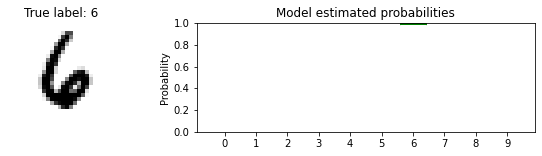

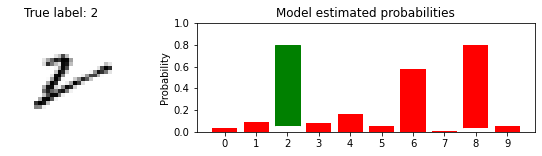

In [21]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)

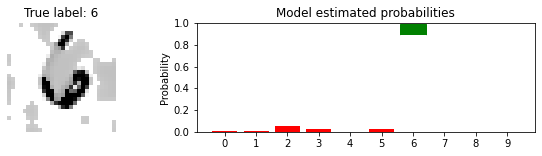

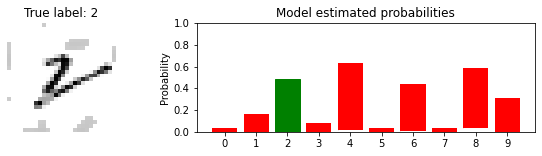

In [24]:
# Prediction examples on MNIST-C

for i in [0, 1577]:
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)